In [1]:
import os
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.feature_selection import mutual_info_classif

from zipfile import ZipFile
from pathlib import Path
from tqdm import tqdm




In [2]:
warnings.filterwarnings('ignore')

In [3]:
volunteer_id = '0'

In [4]:
def get_measurements_df(volunteer, state, filename, pilot = True, experiment = 'pre'):
    DATASET_PATH = Path('cogwear-can-we-detect-cognitive-effort-with-consumer-grade-wearables-1.0.0')
    assert state in ['baseline', 'cognitive_load'], 'Not existing volunteer state passed'
    
    measurements_path = str(DATASET_PATH / 'pilot' / str(volunteer) / state / filename)
    
    if pilot:
        return pd.read_csv(measurements_path)
        
    measurements_path = str(DATASET_PATH / 'survey_gamification' / str(volunteer) / experiment / state / filename)
    return  pd.read_csv(measurements_path)


def compare_measurement(volunteer_id, data_filename, compare_columns, suptitle_text = ''):

    base_df = get_measurements_df(0, 'baseline', data_filename)
    load_df = get_measurements_df(0, 'cognitive_load', data_filename)

    nrows = len(signal_columns)

    fig, ax = plt.subplots(nrows=len(signal_columns), 
                           ncols=2, figsize=(10, 3 * nrows), 
                           squeeze=False,
                          sharey=True)
    for i, c in enumerate(signal_columns):

        ax[i, 0].plot(load_df['time'], load_df[c])
        ax[i, 0].set_title('Cognitive Load')
        ax[i, 0].set_ylabel(c)

        ax[i, 1].plot(base_df['time'], base_df[c])
        ax[i, 1].set_title('Baseline')

    fig.suptitle(suptitle_text)
    fig.tight_layout()

# EDA

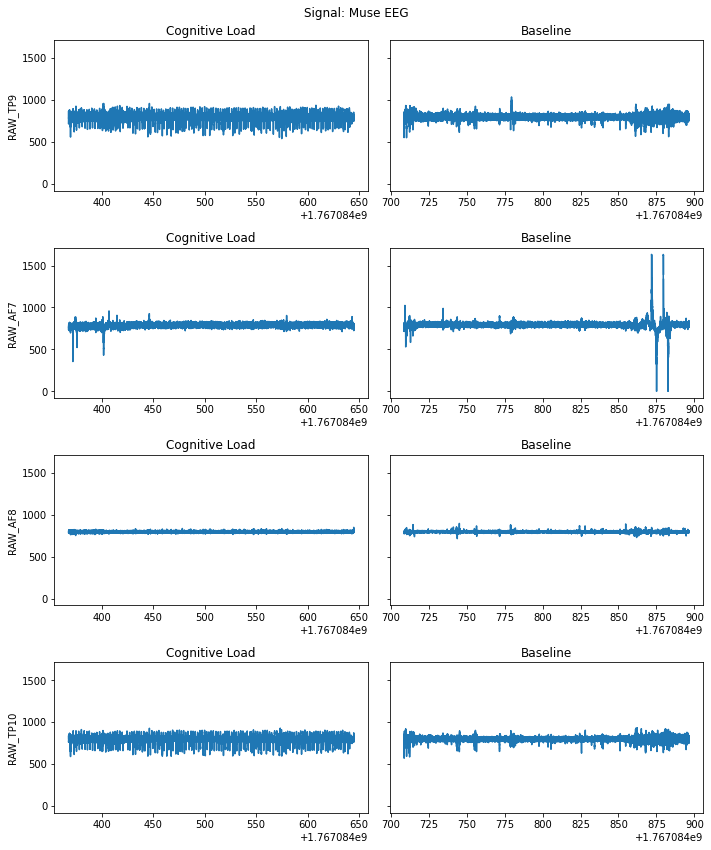

In [5]:
signal_columns = [ 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']
signal_name = 'Signal: Muse EEG'
signal_filename = 'muse_eeg.csv'

compare_measurement(volunteer_id, signal_filename, signal_columns, suptitle_text=signal_name)

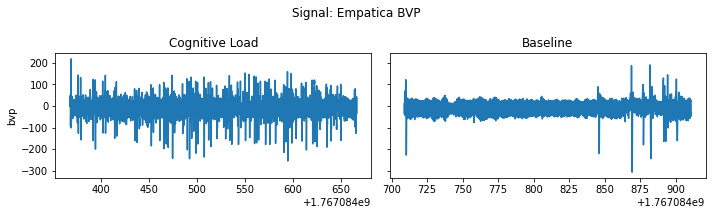

In [6]:
signal_columns = ['bvp']
signal_name = 'Signal: Empatica BVP'
signal_filename = 'empatica_bvp.csv'

compare_measurement(volunteer_id, signal_filename, signal_columns, suptitle_text=signal_name)

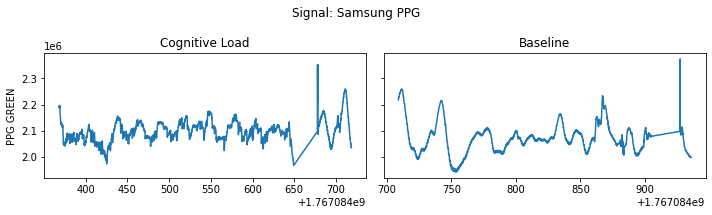

In [7]:
# Comparing samsung bvp

signal_columns = ['PPG GREEN']
signal_name = 'Signal: Samsung PPG'
signal_filename = 'samsung_bvp.csv'

compare_measurement(volunteer_id, signal_filename, signal_columns, suptitle_text=signal_name)

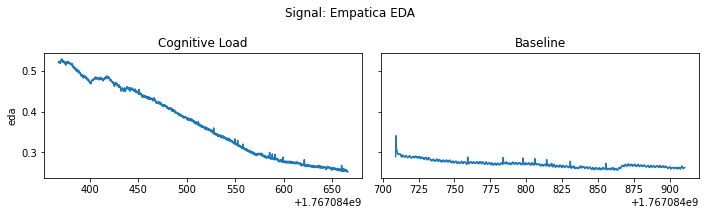

In [8]:
signal_columns = ['eda']
signal_name = 'Signal: Empatica EDA'
signal_filename = 'empatica_eda.csv'

compare_measurement(volunteer_id, signal_filename, signal_columns, suptitle_text=signal_name)

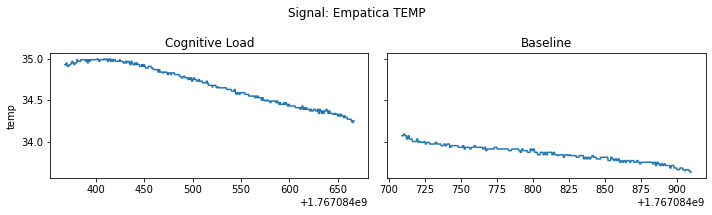

In [9]:
signal_columns = ['temp']
signal_name = 'Signal: Empatica TEMP'
signal_filename = 'empatica_temp.csv'

compare_measurement(volunteer_id, signal_filename, signal_columns, suptitle_text=signal_name)

# Feature engineering

In [10]:
features = ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']
muse_df = get_measurements_df(0, 'cognitive_load', 'muse_eeg.csv')[features]

In [11]:
def get_time_domain_from_fs_range(frequencies_range, spectrum, frequencies, signal_length):
    start_range, end_range = frequencies_range
    indices = np.where((frequencies >= start_range) & (frequencies <= end_range))
    mask = np.zeros(signal_length, dtype=complex)
    mask[indices] = spectrum[indices]
    return np.real(np.fft.ifft(mask))

def get_alpha_and_theta_readings(signal_df):

    electrodes = ['RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'RAW_TP9']
    assert len(set(electrodes) & set(signal_df.columns)) == len(electrodes)
    
    df = pd.DataFrame()
    new_columns = []
    
    for e in electrodes:
        signal = signal_df[e].ffill()
        
        spectrum = np.fft.fft(signal)
        frequencies = np.fft.fftfreq(len(signal_df), d=1/256)
        
        
        theta_range = [4, 7]
        alpha_range = [8, 13]
        df[f'{e}_ALPHA'] = get_time_domain_from_fs_range(alpha_range, spectrum, frequencies, len(signal_df) )
        df[f'{e}_THETA'] = get_time_domain_from_fs_range(theta_range, spectrum, frequencies, len(signal_df) )
        
        new_columns.append(f'{e}_ALPHA')
        new_columns.append(f'{e}_THETA')
        
        
        
    df['time'] = signal_df['time']
        
    return df, new_columns

In [13]:
load_df, signal_columns = get_alpha_and_theta_readings(get_measurements_df(0, 'cognitive_load', 'muse_eeg.csv'))

In [15]:
base_df, _  = get_alpha_and_theta_readings(get_measurements_df(0, 'baseline', 'muse_eeg.csv'))

In [16]:
def plot_signal_comparison(load_df, base_df, columns):
    fig, ax = plt.subplots(nrows=len(columns), 
                           ncols=2, figsize=(10, 3 * len(columns)), 
                           squeeze=False,
                          sharey=True)
    for i, c in enumerate(columns):
            ax[i, 0].plot(load_df['time'], load_df[c])
            ax[i, 0].set_title('Cognitive Load')
            ax[i, 0].set_ylabel(c)

            ax[i, 1].plot(base_df['time'], base_df[c])
            ax[i, 1].set_title('Baseline')

    fig.tight_layout()

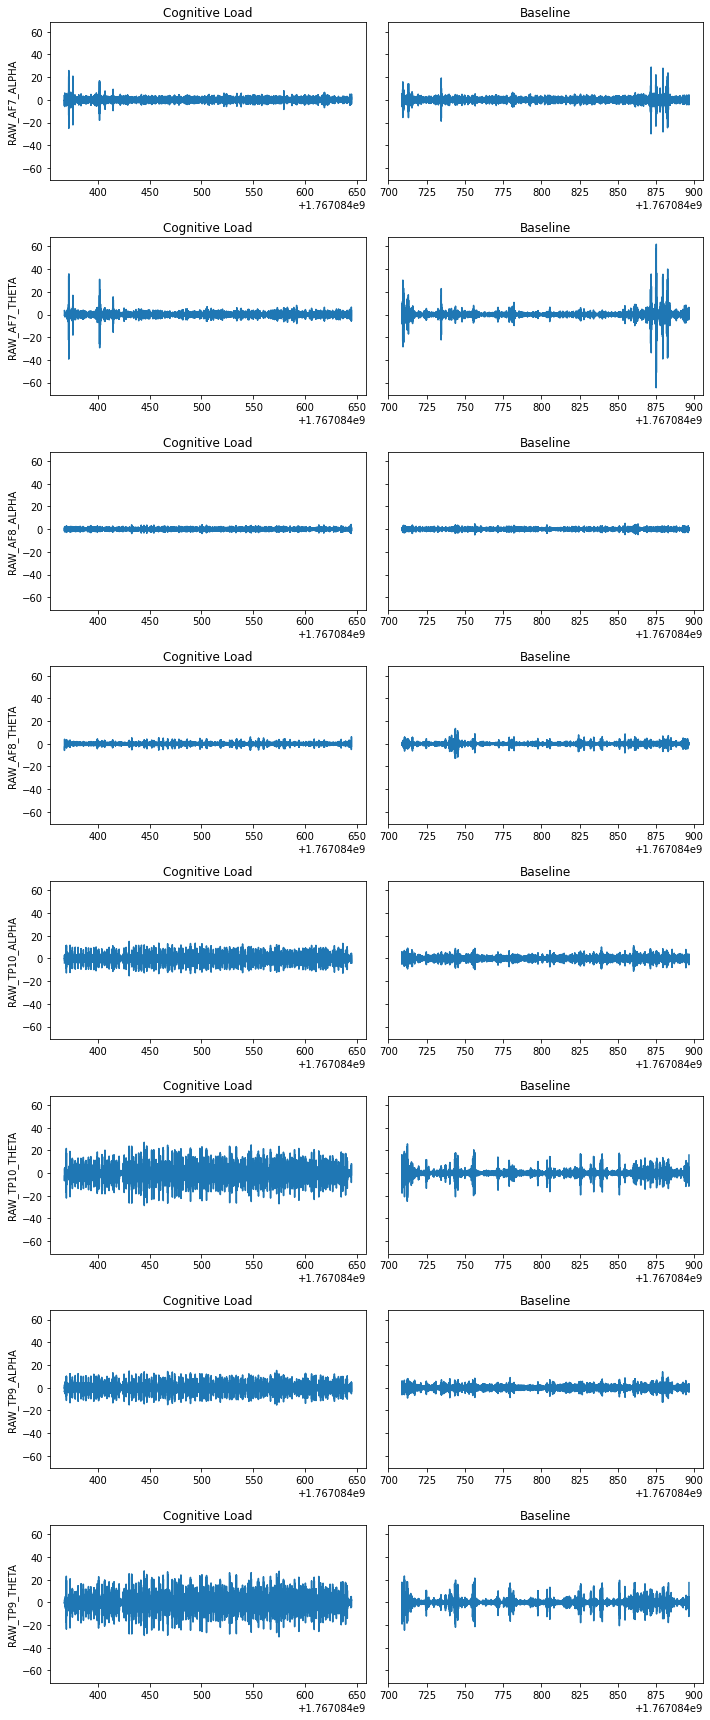

In [17]:
plot_signal_comparison(load_df, base_df, signal_columns)

In [18]:
def get_features_in_frequencies_range(e_name, frequencies_range, frequencies, spectrum):
    start_range, end_range = frequencies_range
    selected_freq = np.where((frequencies > start_range) & (frequencies < end_range))
    selected_spectrum = np.real(spectrum[selected_freq])
    
    mean = np.mean(selected_spectrum)
    std = np.std(selected_spectrum)
    max_a = np.max(selected_spectrum)
    min_a = np.min(selected_spectrum)
    energy = np.sum(selected_spectrum)
    
    d = {
        e_name + '_mean' : mean,
        e_name + '_std': std,
        e_name + '_max': max_a,
        e_name +'_min': min_a,
        e_name + '_energy': energy
    }
    s = pd.Series(d)
    
    return s

        
def get_alpha_and_theta_features(signal_df):
    electrodes = ['RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'RAW_TP9']

    df = pd.DataFrame()
    new_columns = []

    for e in electrodes:
        signal = signal_df[e].fillna(0)

        spectrum = np.fft.fft(signal)
        frequencies = np.fft.fftfreq(len(signal_df), d=1/256)

        theta_range = [4, 7]
        alpha_range = [8, 13]
        s_theta = get_features_in_frequencies_range(e + '_theta', theta_range, frequencies, spectrum)
        s_alpha = get_features_in_frequencies_range(e + '_alpha', alpha_range, frequencies, spectrum)

        e_s = pd.concat([s_theta, s_alpha])
        df = pd.concat([df, e_s], axis=0)

    return df.T
    

In [19]:
get_alpha_and_theta_features(muse_df)

,RAW_AF7_theta_mean,RAW_AF7_theta_std,RAW_AF7_theta_max,RAW_AF7_theta_min,RAW_AF7_theta_energy,RAW_AF7_alpha_mean,RAW_AF7_alpha_std,RAW_AF7_alpha_max,RAW_AF7_alpha_min,RAW_AF7_alpha_energy,...,RAW_TP9_theta_mean,RAW_TP9_theta_std,RAW_TP9_theta_max,RAW_TP9_theta_min,RAW_TP9_theta_energy,RAW_TP9_alpha_mean,RAW_TP9_alpha_std,RAW_TP9_alpha_max,RAW_TP9_alpha_min,RAW_TP9_alpha_energy
0,283.282227,8849.234281,28066.650873,-30852.65022,235974.095092,-18.897124,7356.277422,29332.804351,-61562.91754,-26248.105056,...,142.85174,17747.877572,66548.626118,-59217.488578,118995.499791,-162.786474,8475.672204,31687.079368,-58020.953009,-226110.411748


# Loading data

In [20]:
X_pilot = pd.DataFrame()

for i in range(11):
    for load, load_name in zip([0, 1], ['baseline', 'cognitive_load']):
        try:
            measurements_df = get_measurements_df(i, load_name, 'muse_eeg.csv', pilot=True)

            features_df = get_alpha_and_theta_features(measurements_df)
            features_df['Load'] = load
            X_pilot = pd.concat([X_pilot, features_df], ignore_index=True)
        except FileNotFoundError as e:
            pass
        
print(f'Total number of rows: {len(X_pilot)}')

Total number of rows: 20


In [21]:
X_survey = pd.DataFrame()

for volunteer_id in range(11, 25):
    for experiment_i in ['pre', 'post']:
        for load, load_name in zip([0, 1], ['baseline', 'cognitive_load']):
            try:
                measurements_df = get_measurements_df(volunteer_id, load_name, 'muse_eeg.csv',
                                                     pilot=False, experiment=experiment_i)

                features_df = get_alpha_and_theta_features(measurements_df)
                features_df['Load'] = load
                X_survey = pd.concat([X_survey, features_df], ignore_index=True)
            except FileNotFoundError as e:
                pass
print(f'Total number of rows: {len(X_survey)}')

Total number of rows: 43


In [22]:
X_full = pd.concat([X_pilot, X_survey])

# Selecting features

In [31]:
mi_features = mutual_info_classif(X_full.drop(columns=['Load']), X_full['Load'], random_state=42)

In [32]:
mi_scores = pd.DataFrame({
    'feature_name': X_full.drop(columns=['Load']).columns,
    'mi_score': mi_features
}).sort_values(by='mi_score', ascending=False)

high_mi_score = mi_scores[mi_scores['mi_score'] > 0.1]
high_mi_score

,feature_name,mi_score
13,RAW_AF8_theta_min,0.220517
17,RAW_AF8_alpha_max,0.192037
31,RAW_TP9_theta_std,0.163760
2,RAW_AF7_theta_max,0.156755
16,RAW_AF8_alpha_std,0.150241
38,RAW_TP9_alpha_min,0.149124
26,RAW_TP10_alpha_std,0.147388
8,RAW_AF7_alpha_min,0.145821
23,RAW_TP10_theta_min,0.131258
22,RAW_TP10_theta_max,0.125820


In [33]:
selected_features = high_mi_score['feature_name'].tolist()
selected_features

['RAW_AF8_theta_min',
 'RAW_AF8_alpha_max',
 'RAW_TP9_theta_std',
 'RAW_AF7_theta_max',
 'RAW_AF8_alpha_std',
 'RAW_TP9_alpha_min',
 'RAW_TP10_alpha_std',
 'RAW_AF7_alpha_min',
 'RAW_TP10_theta_min',
 'RAW_TP10_theta_max',
 'RAW_AF7_theta_energy',
 'RAW_AF7_theta_min',
 'RAW_AF8_theta_std',
 'RAW_TP9_theta_energy',
 'RAW_TP9_theta_max',
 'RAW_AF7_alpha_std',
 'RAW_AF7_alpha_max',
 'RAW_AF7_alpha_energy',
 'RAW_AF8_theta_max']

# Evaluating model

In [39]:
def evaluate_model(X, selected_features, iterations = 1000):
    test_accuracy = []
    train_accuracy = []
    X_copy = X.copy()
    y = X_copy.pop('Load')
    
    X_copy = X_copy[selected_features]
   
    for i in tqdm(range(iterations)):
        X_train, X_test, y_train, y_test = train_test_split(X_copy, y, train_size=0.8, shuffle=True)
        model = SVC()
        model.fit(X_train, y_train)
        
        
        
        train_accuracy.append(model.score(X_train, y_train))
        test_accuracy.append(model.score(X_test, y_test))
        
    return pd.DataFrame({
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy
    })
        
    

In [40]:
evaluate_model(X_full, selected_features).mean()

100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 197.90it/s]


train_accuracy    0.796140
test_accuracy     0.713923
dtype: float64